## **Proyecto final**  
## *Busqueda de genes determinantes para diferencia pacientes con enfermedad de Alzheimer de individuos sanos utilizando datos transcriptómicos*
#### Josué J. R. Rivera Osorio

Cargamos los archivos necesarios que son:  
1) los datos de expresion de los genes en todas las muestras,  
2) las etiquetas para cada muestra (AD: alzheimer y ND: control)

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score, precision_score

#datos de expresion
exp=pd.read_csv('GSE132903_exp.csv', index_col=0)
#labels de sujetos de prueba
label=pd.read_csv('GSE132903_features.csv')
print(exp.shape)

(12976, 195)


Primero observaremos la distribución de los datos de expresión de los pacientes para ver que tan comparables son. Utilizaremos boxplots de cada uno de los pacientes para ver la distribución de sus datos de expresion, y utilizaremos el método describe para tener una idea general de los valores

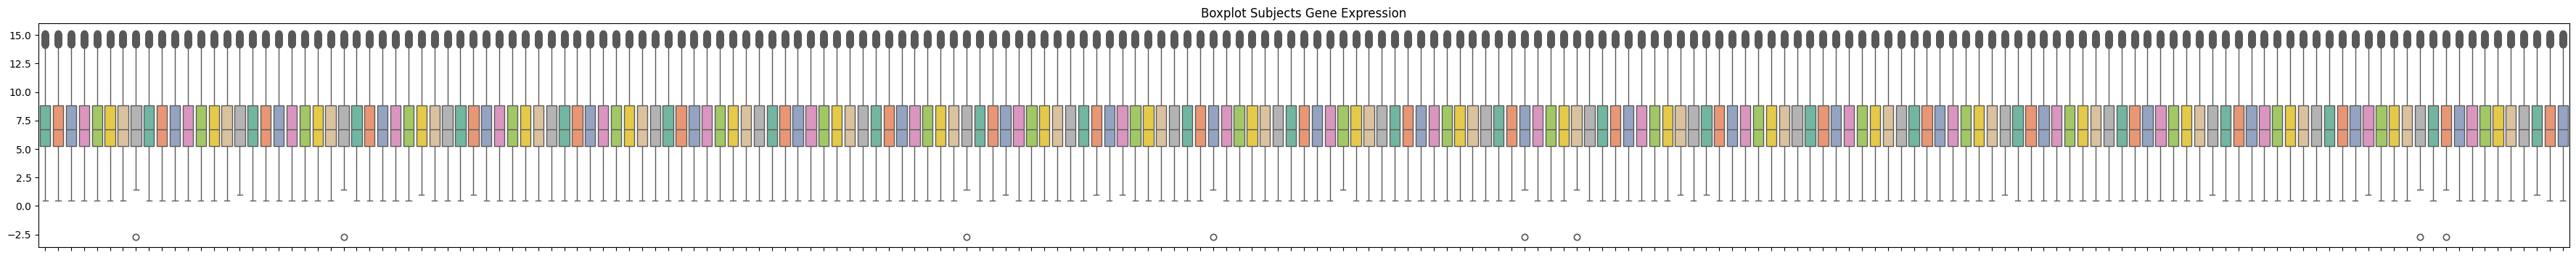

El valor más pequeño del dataframe es: -2.73212032592943
El valor más grande del dataframe es: 15.1345400378029
Existen 186 valores vacíos


In [2]:
#boxplot de pacientes
plt.figure(figsize=(45, 4))
ax = sns.boxplot(data=exp, palette="Set2")
ax.set(title='Boxplot Subjects Gene Expression')
ax.set_xticklabels([])
plt.show()

#observamos la información del dataframe
describe=exp.describe()
minimo=describe.transpose()['min'].min().astype(str)
maximo=describe.transpose()['max'].max().astype(str)
print(f'El valor más pequeño del dataframe es: {minimo}')
print(f'El valor más grande del dataframe es: {maximo}')

#buscamos NaNs
na_counts = exp.isnull().sum().sum()
print(f'Existen {na_counts} valores vacíos')

 A simple vista vemos que no será necesario realizar una normalización, los datos son bastante comparables con numerros entre el -2 y el 15, y parecen tener una media y una dispersión bastante homogenea entre las muestras  
 Extraemos sujetos de muestra para poder reportar la distribución de los datos

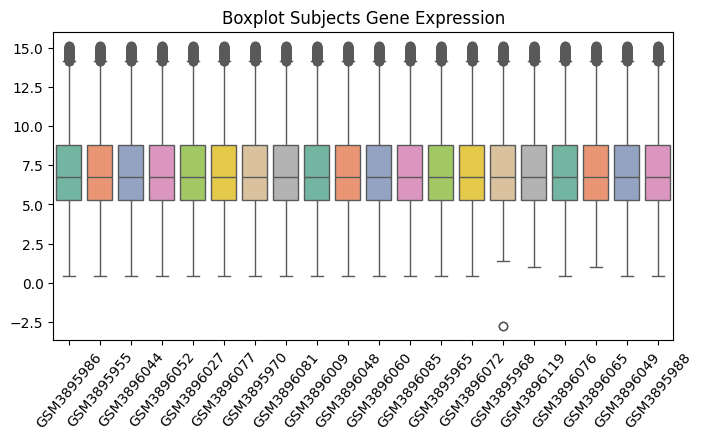

In [3]:
#boxplot de pacientes
# Seleccionar columnas al azar
random_columns = np.random.choice(exp.columns, size=int(round(len(exp.columns) * 0.10)), replace=False)
exp_random = exp[random_columns]

plt.figure(figsize=(8, 4))
ax = sns.boxplot(data=exp_random, palette="Set2")
ax.set(title='Boxplot Subjects Gene Expression')
plt.xticks(rotation=50)
plt.show()

Debido a que existen 186 valores vacíos que si veo es que necesitarémos una imputación.  
Para hacer la imputación primero debemos acomodar el dataframe a la forma correcta, trasponerlo para tener los features en las columnas y los registros de los pacientes en cada fila.

In [4]:
#trasponemos y acomodamos el dataframe
exp_t=exp.transpose().reset_index().rename(columns={'index':'geo_accession'})

#imputamos los valore de cada una de las columnas
for gene in list(exp_t.columns):
    if gene=='geo_accession':
        pass
    else:
        A2_values = exp_t[gene].values
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
        A2_new_values = imp.fit_transform(A2_values.reshape(-1,1))
        A2_new_values
        exp_t[gene] = A2_new_values.reshape(-1,)

#validamos que no haya valores vacíos
na_counts = exp_t.isnull().sum().sum()
print(f'Existen {na_counts} valores vacíos')

Existen 0 valores vacíos


Ya con los datos limpios y normalizados procedemos a intentar entrenar los primeros clasificadores  
Primero podemos visualizar los datos utilizando un PCA para ver si se nota algun tipo de dispersión entre los AD y los ND  

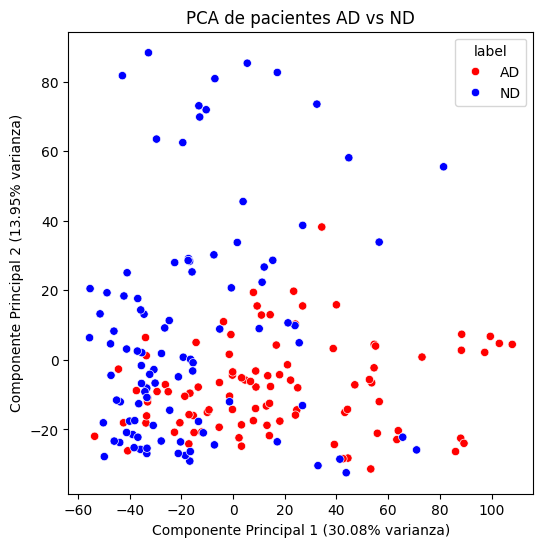

In [5]:
#primero nos aseguramos que todas las columnas sean valor str
exp_t.columns=list(exp_t.columns.astype(str))

#cruzamos para obtener la etiqueda de su condición ['ND', 'AD'] #ND: non deseases, AD:alzheimer disease
data=exp_t.merge(label, how='left').drop(columns=['geo_accession', 'title', 'age', 'sex']).copy()
labels = data['label']
data = data.drop(columns=['label'])

# # Aplicar VarianceThreshold
# var_thresh = VarianceThreshold(threshold=0.01)  # Ajusta el umbral según tus necesidades
# data_reduced = var_thresh.fit_transform(data)

# creamos el PCA
pca = PCA(n_components=2)  # Reducimos a 2 componentes principales para la visualización
principal_components = pca.fit_transform(data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['label'] = labels
explained_variance = pca.explained_variance_ratio_

# obtenemos el gráfico de disperción del PCA
plt.figure(figsize=(6, 6))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, palette=['red', 'blue'])
plt.title('PCA de pacientes AD vs ND')
plt.xlabel(f'Componente Principal 1 ({explained_variance[0]:.2%} varianza)')
plt.ylabel(f'Componente Principal 2 ({explained_variance[1]:.2%} varianza)')
plt.show()

Los datos no se distribuyen completamente separados pero si se ve una ligera tendencia a que los AD los explique mejor el CP1 y a los ND el CP2  
Ahora procederemos a probar los clasificadores. Intentaremos usar primero todas las features probando los modelos:  
1) Arbol de Decisión  
2) Random Fores  
3) Regresión Logistica  
4) SVM con kernel lineal

En caso de obtener buenos resultados recogeremos los pesos de las features en la calsificacion así como la importancia de ellas

In [6]:
#cruzamos para obtener la etiqueda de su condición ['ND', 'AD'] #ND: non deseases, AD:alzheimer disease
exp_fin=exp_t.merge(label, how='left').drop(columns=['geo_accession', 'title', 'age', 'sex']).copy()
#separamos las etiquetas de los valores
y=exp_fin['label'].values
#nos quedamos con el dataframe y los features
exp_fin.drop(columns='label',inplace=True)
#separamos los valores
X=exp_fin.values

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### ARBOL DE DECISIÓN

Fitting 5 folds for each of 21 candidates, totalling 105 fits
Best Score: 0.757258064516129
Best Hyperparameters: {'clf__criterion': 'gini', 'clf__max_depth': None}
Accuracy: 0.7948717948717948
Recall: 0.7948717948717948
Precision: 0.8219373219373219


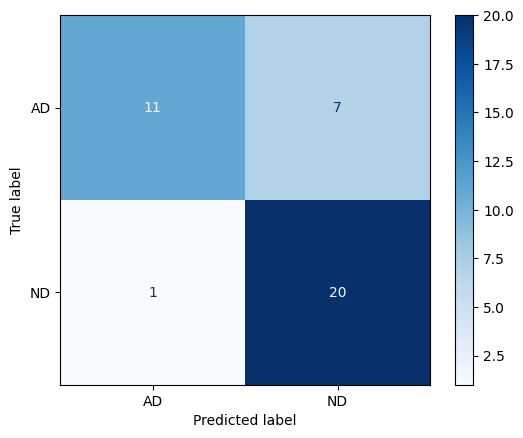

In [7]:
# Definimos el pipeline
pipeline = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])

# Definimos parámetros de busqueda
param_grid = {
    'clf__criterion': ['gini','entropy', 'log_loss'],
    'clf__max_depth': [None, 10, 20, 30, 40, 50, 60]
    # 'clf__min_samples_split': [2, 10, 20],
    # 'clf__min_samples_leaf': [1, 5, 10],
    # 'clf__max_features': [None, 'sqrt', 'log2']
}

# Configuramos el GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Ajustamos el modelo y muscamos el mejor puntaje
grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_search.best_score_}')

# Evaluamos el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculamos el accuracy, recall y precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Observamos la Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [8]:
# Obtenemos la importancia de las características
feature_importances = best_model.named_steps['clf'].feature_importances_
features = exp_fin.columns

# Creamos un DataFrame con la importancia de las características
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Escogemos las 30 con mayor peso
importance_df=importance_df.head(30)
importance_df['MODELO']='DT'

### REGRESION LOGISTICA

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Score: 0.8977822580645162
Best Hyperparameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Accuracy: 0.8717948717948718
Recall: 0.8717948717948718
Precision: 0.8794871794871794


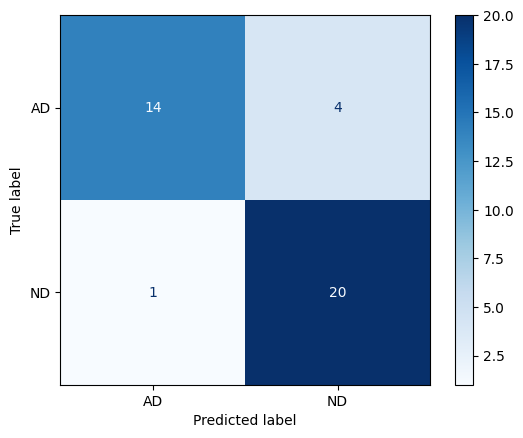

In [9]:
# Definimos el pipeline
pipeline = Pipeline([
    #('poly', PolynomialFeatures()),
    ('clf', LogisticRegression(random_state=42, max_iter=10000))
])

# Definimos parámetros de busqueda
param_grid = [
    {
        #'poly__degree': [1, 2],
        'clf__C': [0.01, 0.1, 1, 10],
        'clf__penalty': ['l1', 'l2'],
        'clf__solver': ['liblinear']
    }
]

# Configuramos el GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Ajustamos el modelo
grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_search.best_score_}')

# Evaluamos el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculamos el accuracy, recall y precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Observamos la Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [10]:
# Extraemos los coeficientes de las características
coefficients = best_model.named_steps['clf'].coef_[0]
features = exp_fin.columns

# Creamos un DataFrame con los coeficientes
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Escogemos las 30 con mayor peso
coefficients_df=coefficients_df.head(30)
coefficients_df['MODELO']='RL'
features_weight=pd.concat([importance_df, coefficients_df])

### RANDOM FOREST  

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Score: 0.859475806451613
Best Hyperparameters: {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 150}
Accuracy: 0.717948717948718
Recall: 0.717948717948718
Precision: 0.727810650887574


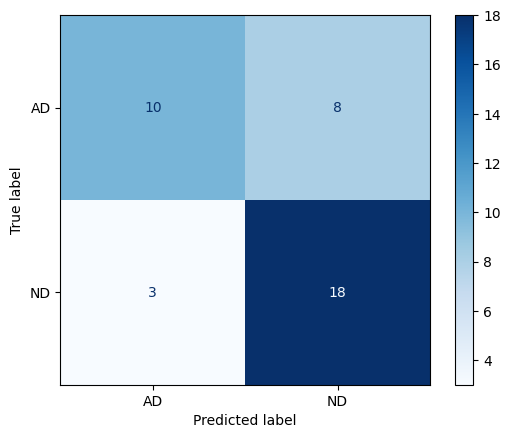

In [11]:
# Definimos el pipeline
pipeline = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])

# Definimos parámetros de busqueda
param_grid = {
    'clf__n_estimators': [100, 150, 200],
    'clf__criterion': ['gini','entropy', 'log_loss'],
    'clf__max_depth': [None, 10, 20, 30]
#    'clf__min_samples_split': [2, 10],
#    'clf__min_samples_leaf': [1, 5, 10],
#    'clf__max_features': [None, 'sqrt', 'log2']
}

# Configuramos el GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Ajustamos el modelo
grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_search.best_score_}')

# Evaluamos el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculamos el accuracy, recall y precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Observamos la Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
# Extraemos los coeficientes de las características
feature_importances = best_model.named_steps['clf'].feature_importances_
features = exp_fin.columns

# Creamos un DataFrame con los coeficientes
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Escogemos las 30 con mayor peso
importance_df=importance_df.head(30)
importance_df['MODELO']='RF'
features_weight=pd.concat([features_weight, importance_df]).copy()

### SUPPORT VECTOR MACHINE 

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Score: 0.904233870967742
Best Hyperparameters: {'clf__C': 0.01}
Accuracy: 0.8717948717948718
Recall: 0.8717948717948718
Precision: 0.8794871794871794


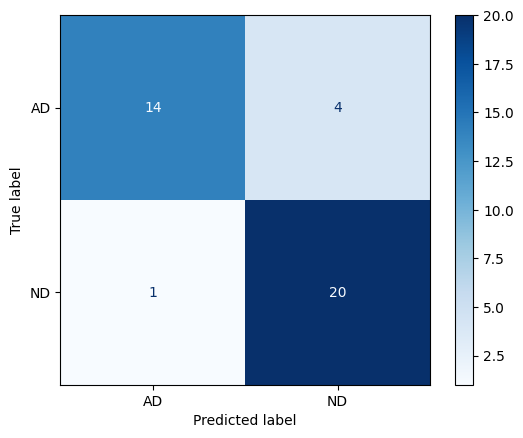

In [13]:
# Definimos el pipeline
pipeline = Pipeline([
    ('clf', SVC(kernel='linear', random_state=42, max_iter=10000))
])

# Definimos parámetros de busqueda
param_grid = [
    {
        'clf__C': [0.01, 0.1, 1, 10]
    }
]

# Configuramos el GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2)

# Ajustamos el modelo
grid_search.fit(X_train, y_train)
print(f'Best Score: {grid_search.best_score_}')

# Evaluamos el mejor modelo
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculamos el accuracy, recall y precision
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')

print(f'Best Hyperparameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')

# Observamos la Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [14]:
# Extraemos los coeficientes de las características
coefficients = best_model.named_steps['clf'].coef_[0]
features = exp_fin.columns

# Creamos un DataFrame con los coeficientes
coefficients_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Escogemos las 30 con mayor peso
coefficients_df=coefficients_df.head(30)
coefficients_df['MODELO']='SVM'
features_weight=pd.concat([features_weight, coefficients_df])

Se obtuvieron buenos resultados con los datos de prueba en los 4 modelos, el mejor fue el support vector machine de kernel lineal, que tuvo un accuracy de 87% muy igual que la regresion logística.  
Para aprovechar estos buenos resultados podemos utilizar todos ellos para revisar cuales son las features (o genes) que tienen mayor peso en cada uno de ellos, por lo que podremos ver que gen o genes se repiten entre clasificadores y

In [16]:
temp=features_weight.reset_index().drop(columns=['index', 'Importance', 'Coefficient']).groupby(by='Feature', as_index=False).count().sort_values(by='MODELO', ascending=False)
temp[temp['MODELO']>1].to_excel('genes_interes.xlsx', index=False)